In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from replay_trajectory_classification import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
INFO:replay_trajectory_classification.load_example_data:Loading Data...
INFO:replay_trajectory_classification.load_example_data:Finding ripple times...


## Sorted Spikes

In [4]:
from replay_trajectory_classification import SortedSpikesClassifier
from dask.diagnostics import ProgressBar 

position = data['position_info'].loc[:, ['x_position', 'y_position']]
is_training = data['position_info'].linear_speed > 4

with ProgressBar():
    classifier = SortedSpikesClassifier().fit(
        position, data['spikes'], is_training=is_training)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


[########################################] | 100% Completed | 14min 19.4s


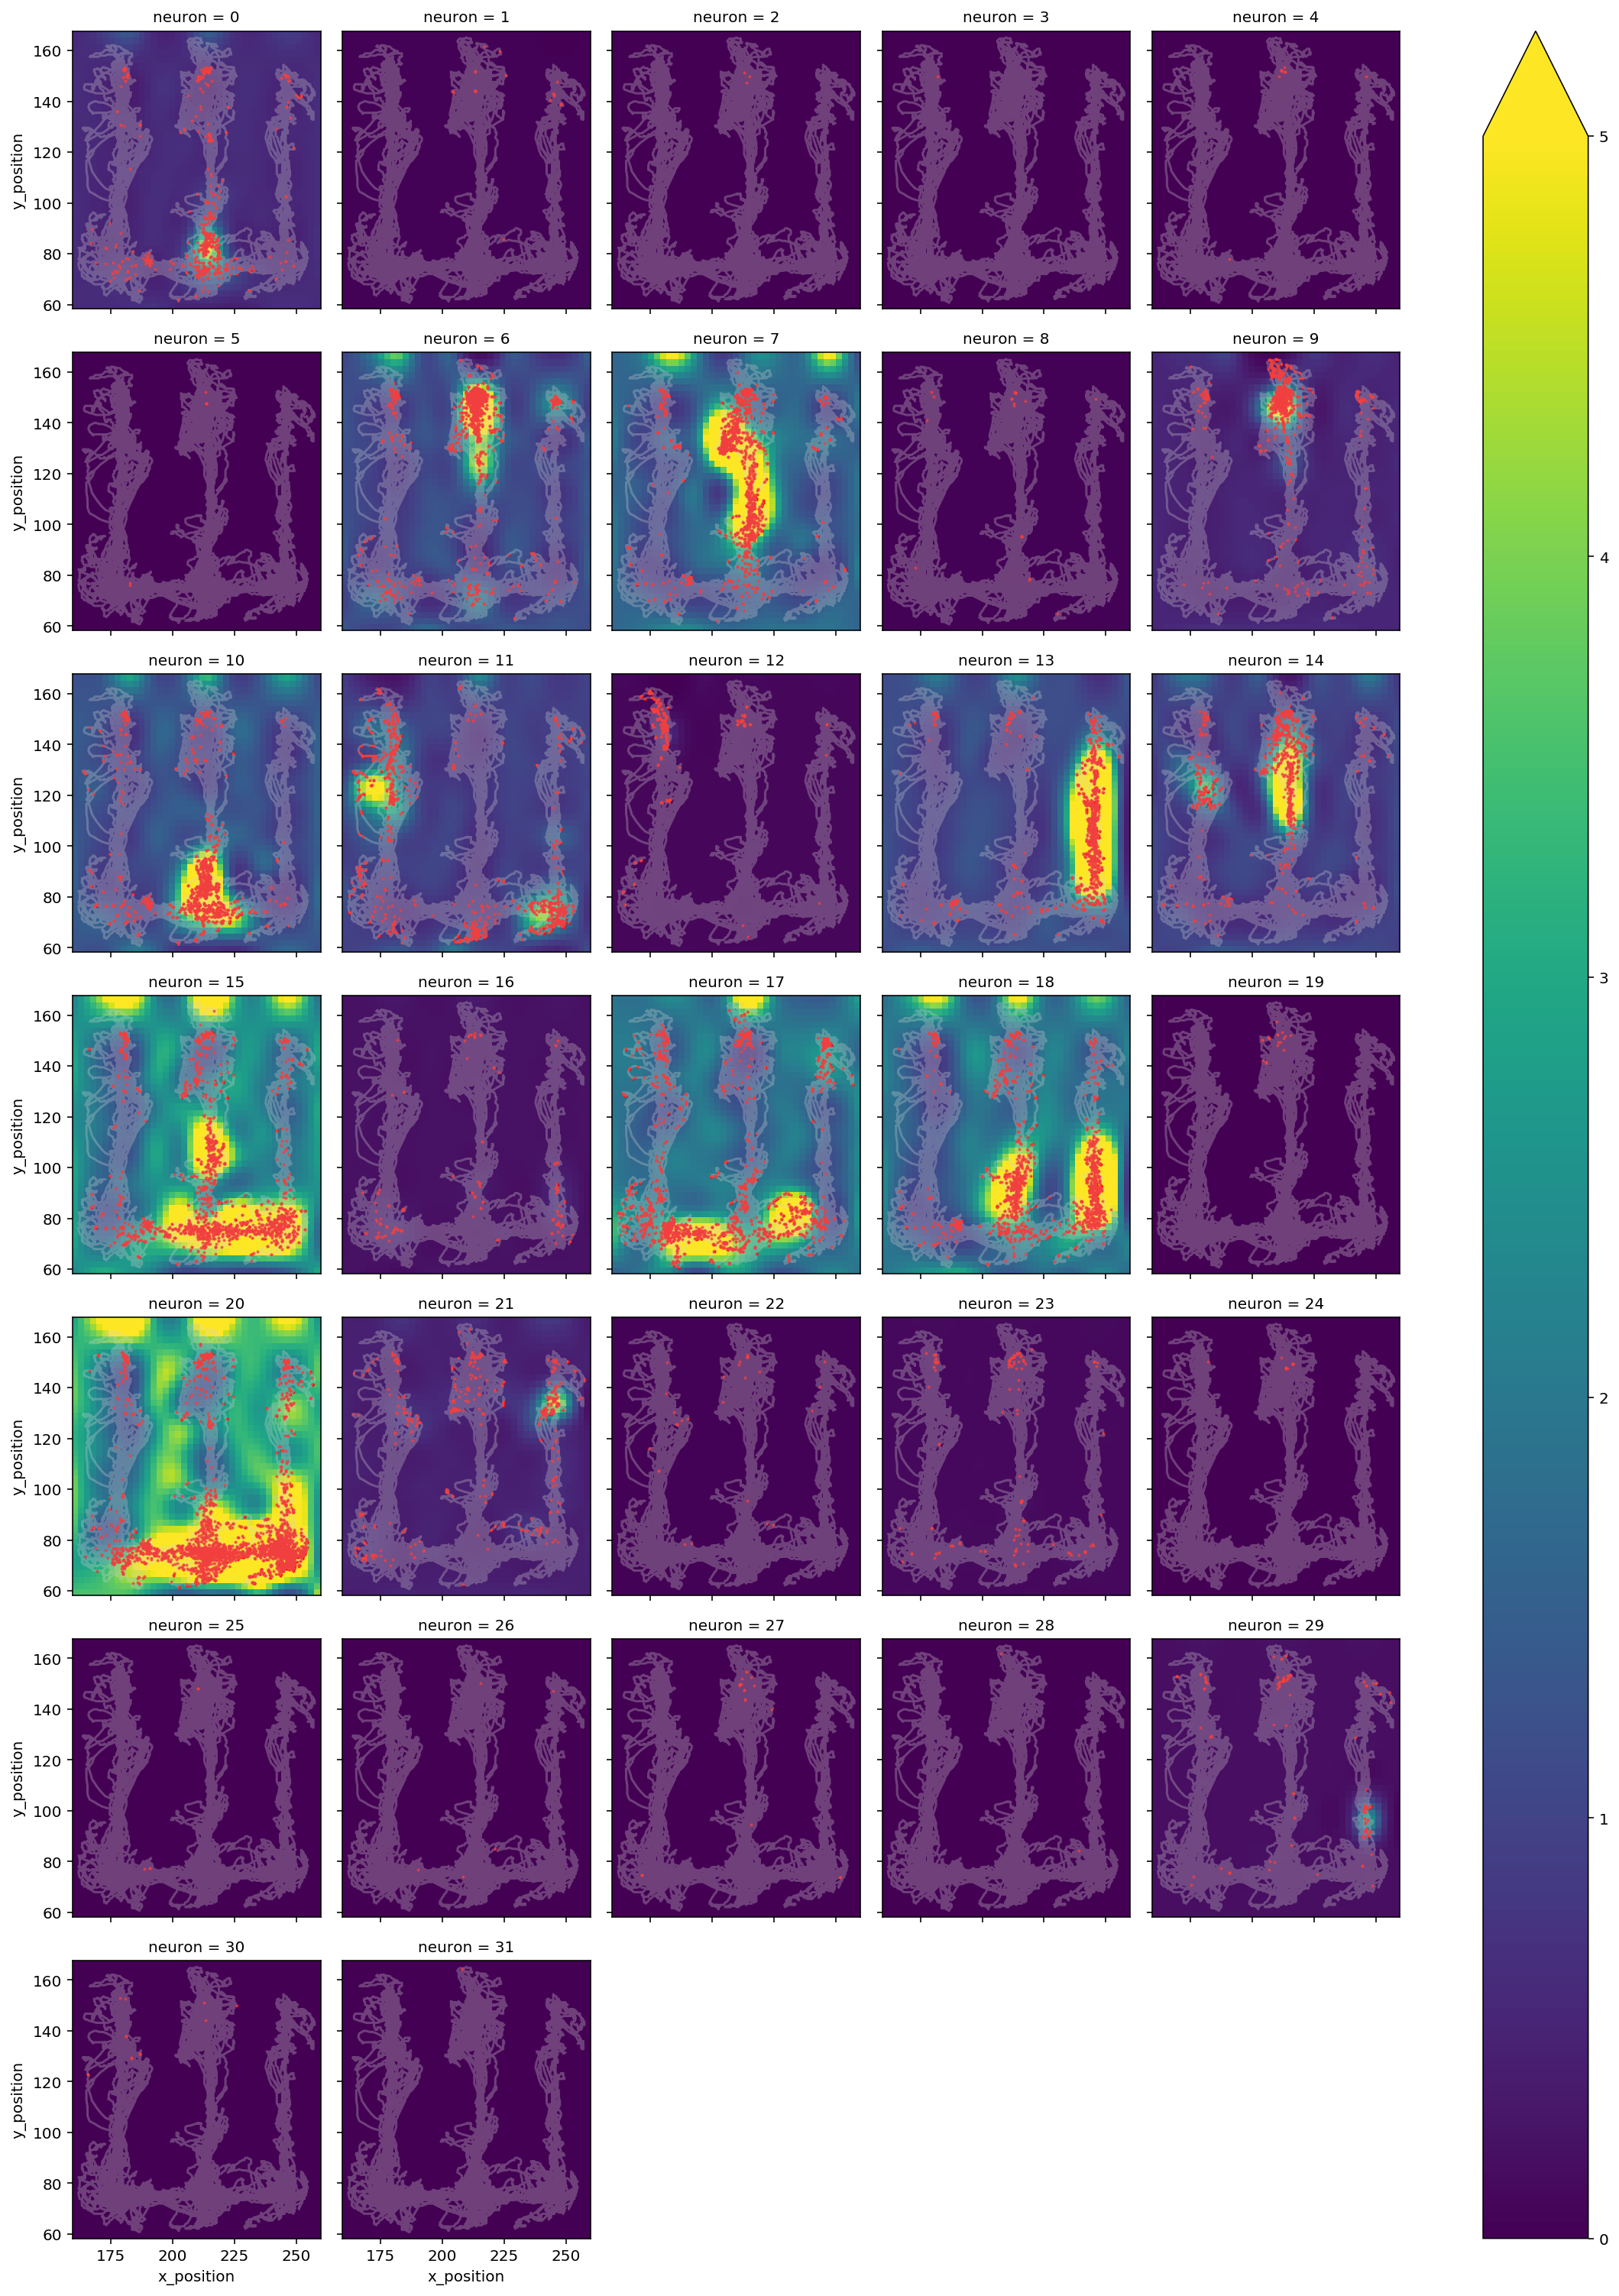

In [5]:
from replay_trajectory_classification.load_example_data import SAMPLING_FREQUENCY

g = (classifier.place_fields_.unstack() * SAMPLING_FREQUENCY).plot(
    x='x_position', y='y_position', col='neuron', col_wrap=5, vmin=0.0, vmax=5.0)

for ax, is_spike in zip(g.axes.flat, data['spikes'].values.T):
    ax.plot(position.iloc[:, 0], position.iloc[:, 1], color='lightgrey', alpha=0.3)
    ax.scatter(position.values[is_spike > 0, 0], position.values[is_spike > 0, 1],
               color='red', s=1, alpha=0.7)

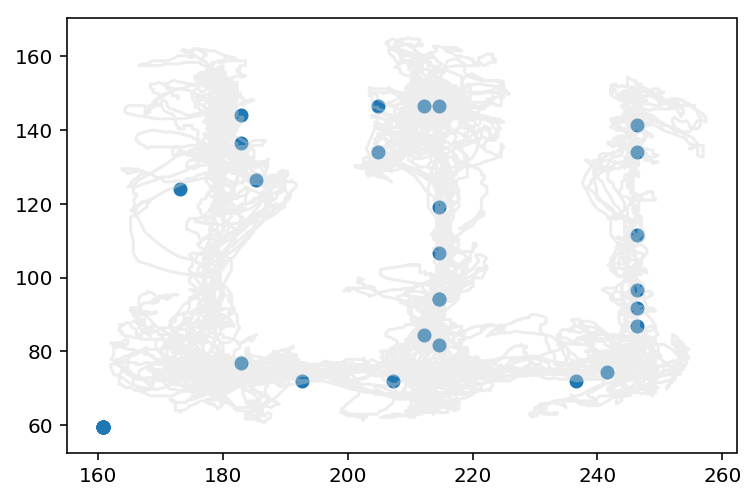

In [6]:
place_field_max = np.asarray(
    classifier.place_fields_.position[classifier.place_fields_.argmax('position')].values.tolist())

plt.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4)
plt.scatter(place_field_max[:, 0], place_field_max[:, 1])

In [7]:
from loren_frank_data_processing import reshape_to_segments

ripple_spikes = reshape_to_segments(
    data['spikes'], data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=SAMPLING_FREQUENCY)

ripple_position = reshape_to_segments(
    data['position_info'].loc[:, ['x_position', 'y_position']],
    data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=SAMPLING_FREQUENCY)

In [8]:
ripple_number = 214

result = classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)

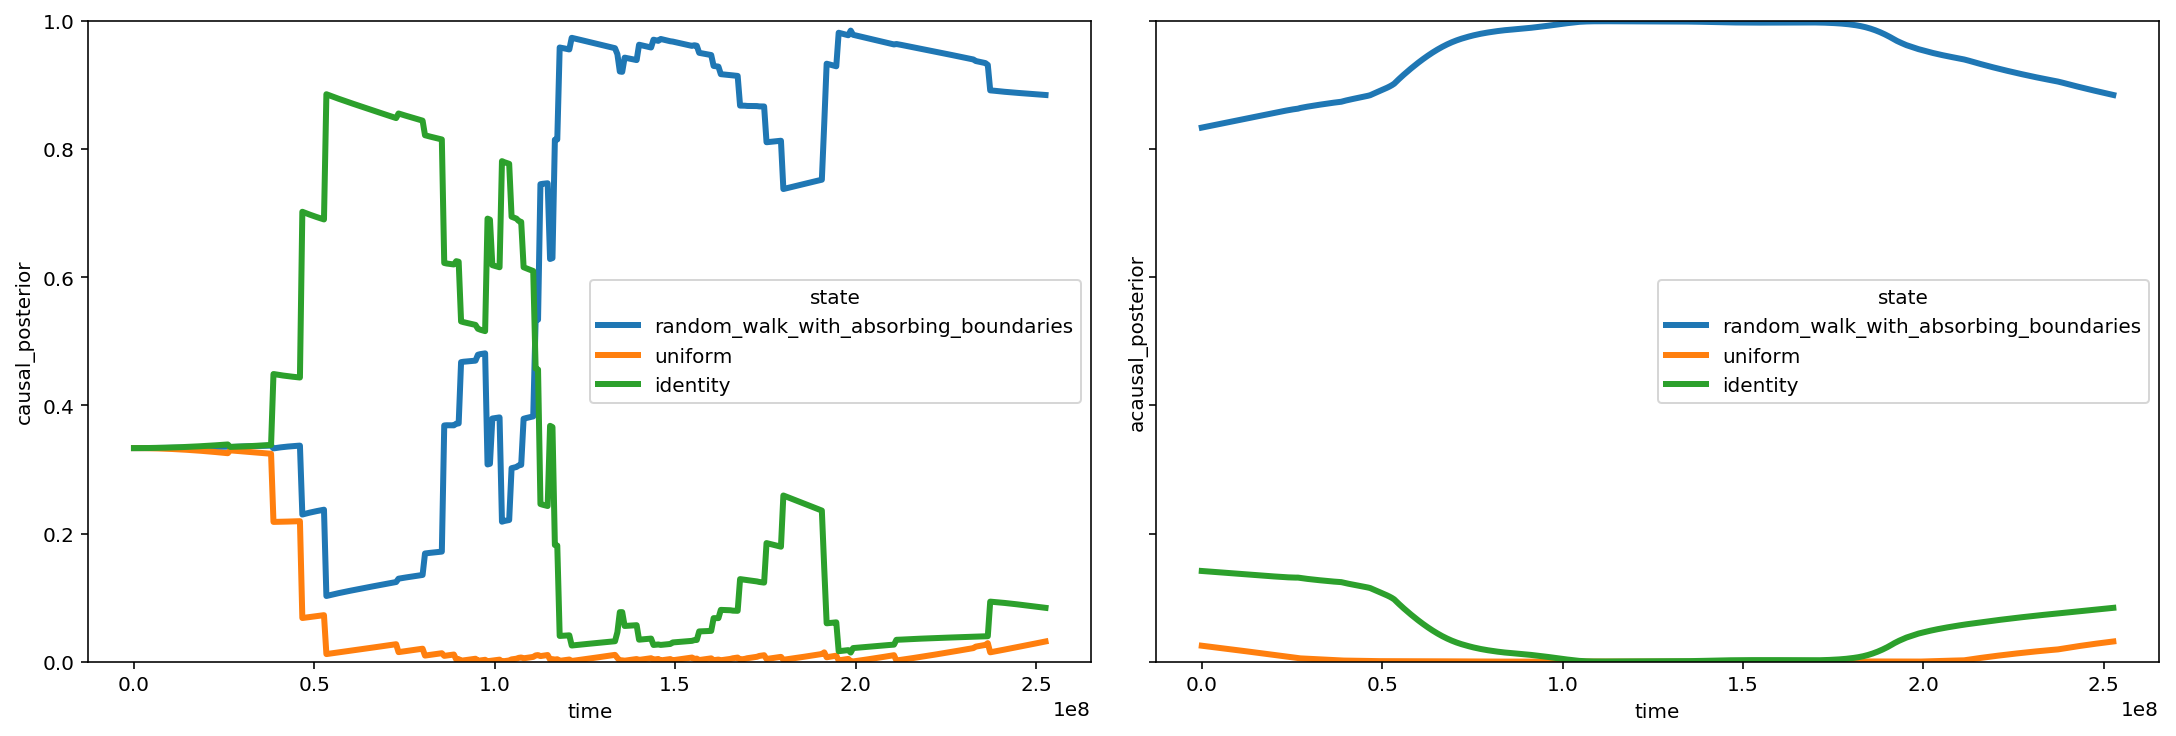

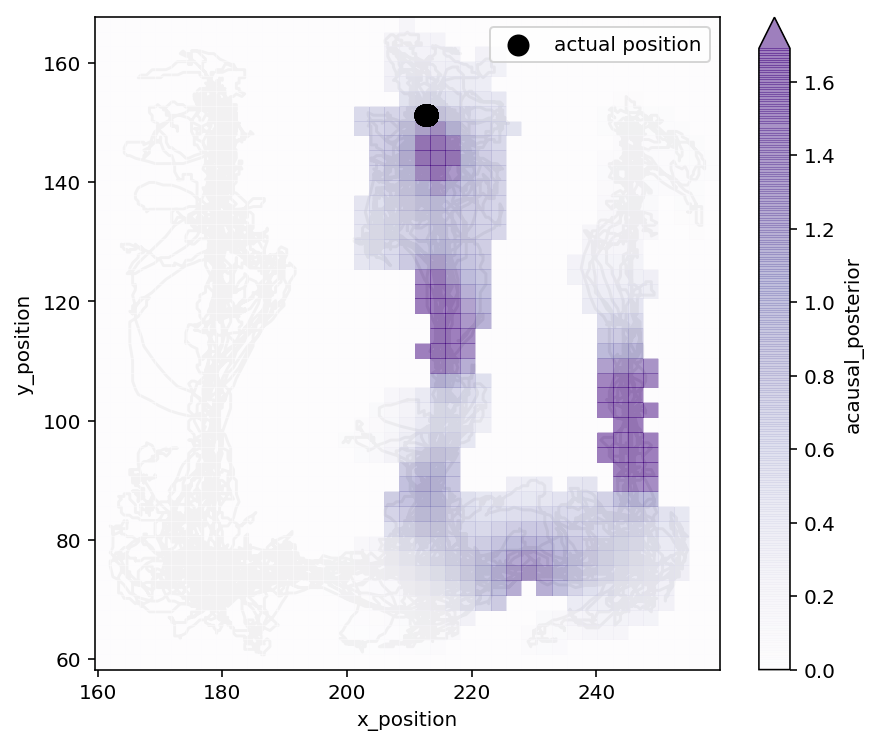

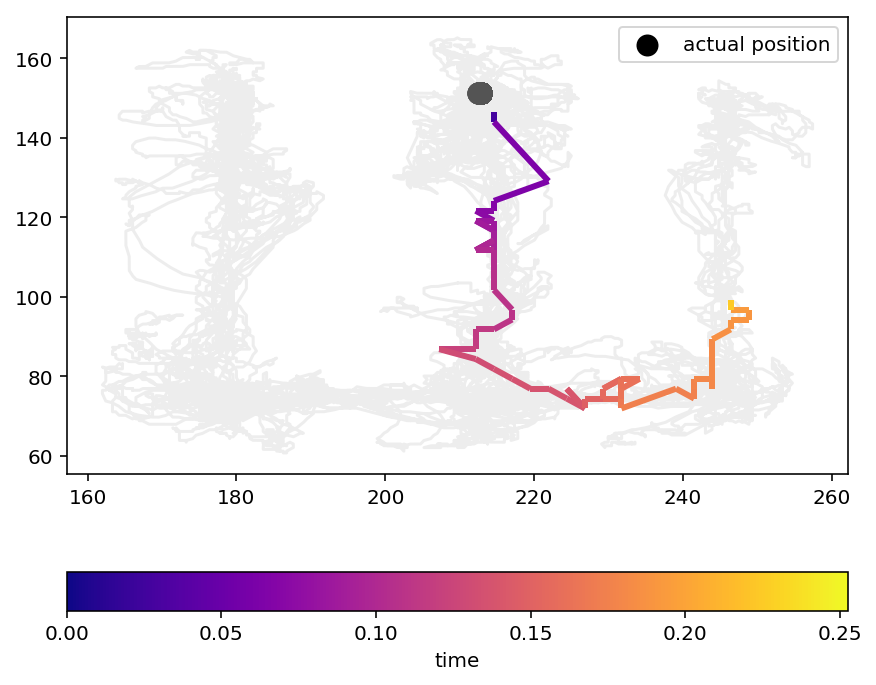

In [9]:
from replay_trajectory_classification.visualization import (
    maximum_a_posteriori_estimate, plot_2D_position_with_color_time)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.5)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.5, zorder=0)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend()

In [14]:
from tqdm.auto import tqdm

results = [classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)
           for ripple_number in tqdm(data['ripple_times'].index)]

In [107]:
probabilties = [classifier.predict_proba(r).acausal_posterior for r in results]
duration = [(p > 0.8).sum('time') / SAMPLING_FREQUENCY for p in probabilties]
duration = xr.concat(duration, dim=data['ripple_times'].index).to_dataframe().unstack(level=1)
to_name = {'identity': 'hover_duration',
           'uniform': 'fragmented_duration',
           'random_walk_with_absorbing_boundaries': 'continuous_duration'}
duration.columns = list(duration.columns.get_level_values('state'))
duration = duration.rename(columns=to_name)
duration = pd.concat((duration, (duration > 0.0).rename(columns=lambda c: c.split('_')[0])), axis=1)

In [ ]:
# import xarray as xr
# from loren_frank_data_processing import save_xarray

# results = xr.concat(results, dim=data['ripple_times'].index)
# save_xarray(pwd, epoch_key, results)

In [47]:
is_classified = np.any(duration > 0, axis=1)
is_classified.sum()

107

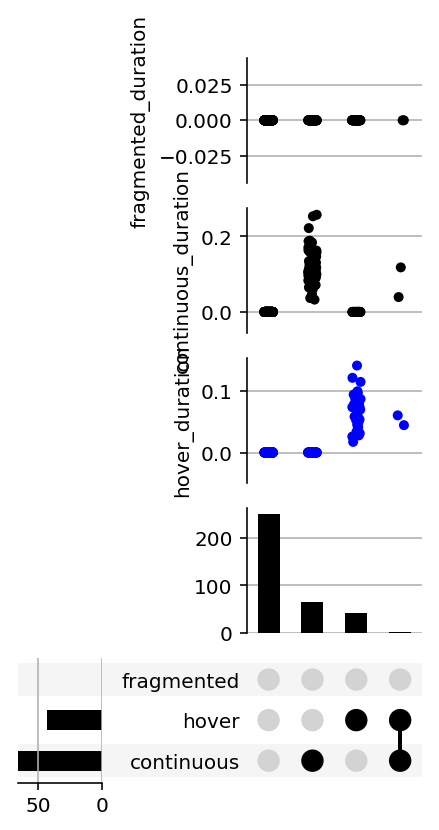

In [115]:
from upsetplot import UpSet
upset = UpSet(duration.set_index(['hover', 'continuous', 'fragmented']),
              sum_over=False, intersection_plot_elements=3)
upset.add_catplot(value='hover_duration', kind='strip', color='blue')
upset.add_catplot(value='continuous_duration', kind='strip', color='black')
upset.add_catplot(value='fragmented_duration', kind='strip', color='black')
upset.plot();

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x1e6a98a160>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x1e6ab72940>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x1e6aa30710>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x1e6a9bdf60>}

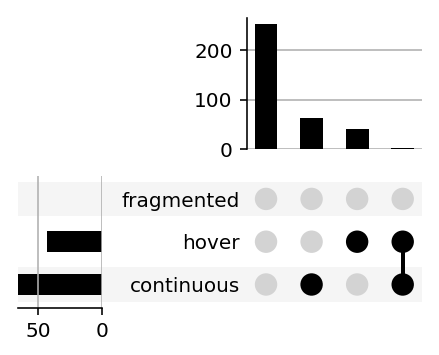

In [116]:
upset = UpSet(duration.set_index(['hover', 'continuous', 'fragmented']),
              sum_over=False, intersection_plot_elements=3)
upset.plot()

In [131]:
duration.loc[duration.iloc[:, 3:5].sum(axis=1) > 1]

hover_duration  continuous_duration  fragmented_duration  \
replay_number                                                             
246                  0.060667             0.039333                  0.0   
284                  0.044667             0.118000                  0.0   

               hover  continuous  fragmented  
replay_number                                 
246             True        True       False  
284             True        True       False

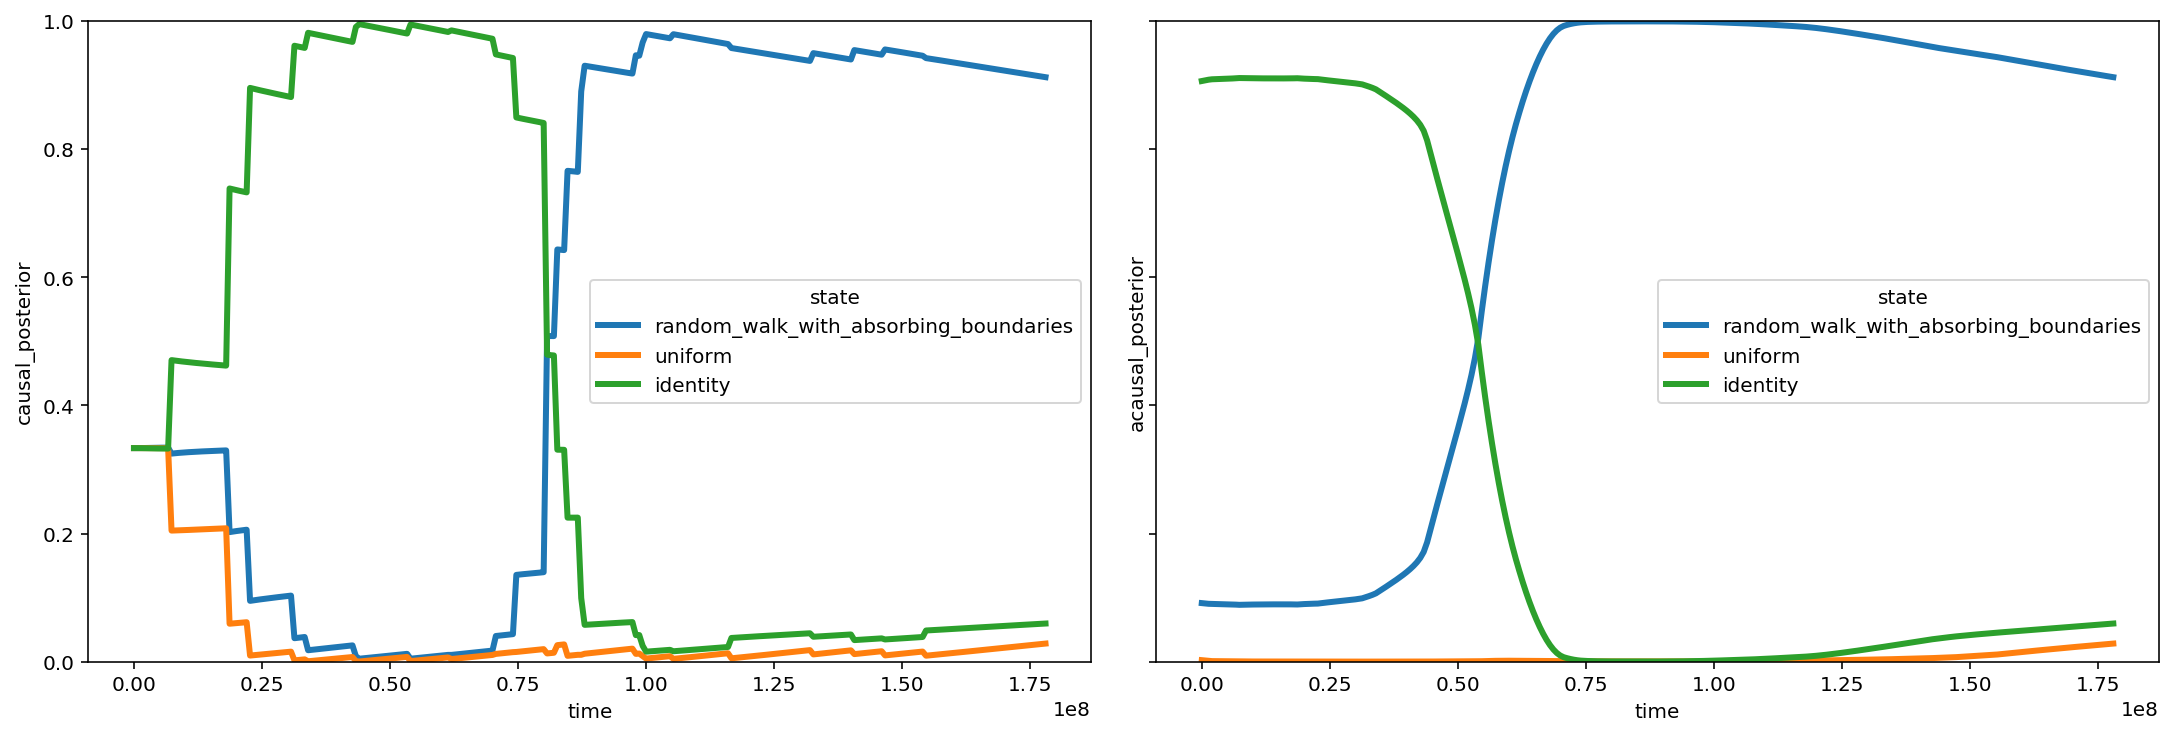

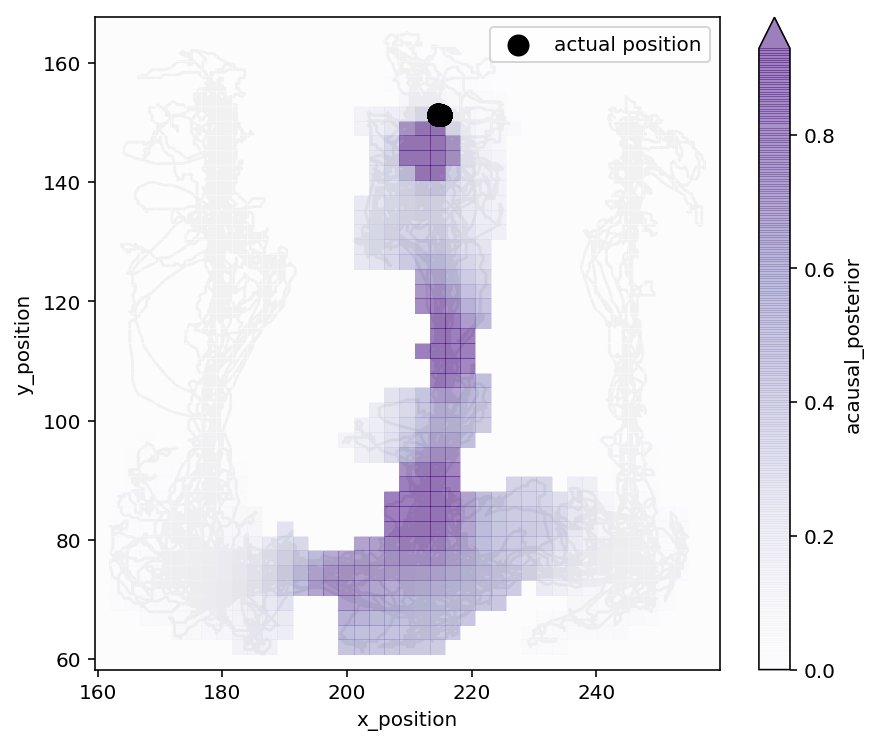

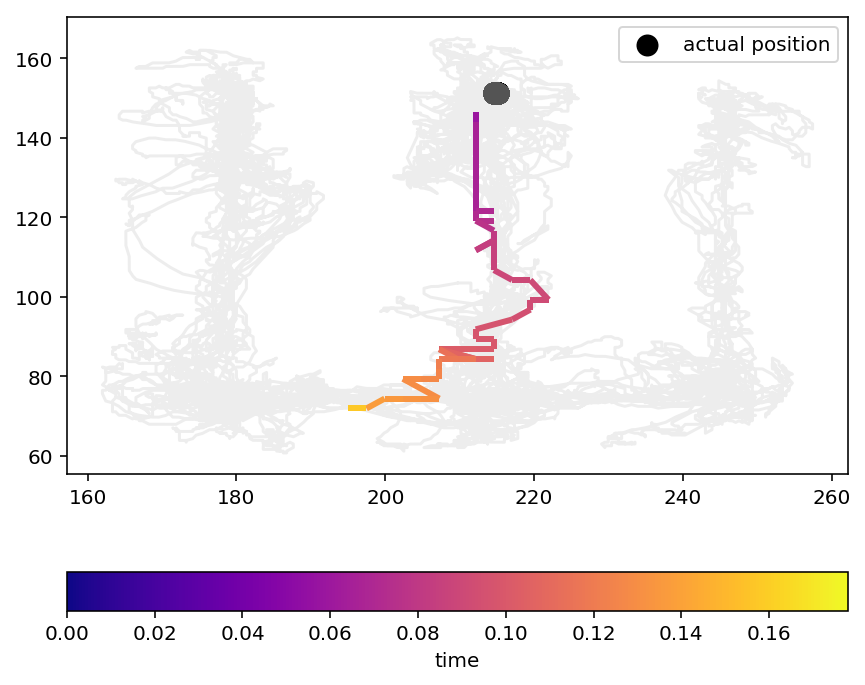

In [137]:
ripple_number = 284
result = results[ripple_number - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.5)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.5, zorder=0)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend()

In [140]:
duration.index[duration.loc[:, 'hover']]

Int64Index([  1,   6,   8,  33,  38, 100, 101, 106, 110, 118, 123, 133, 146,
            152, 153, 158, 160, 177, 183, 184, 187, 201, 204, 205, 212, 216,
            220, 223, 233, 246, 263, 265, 272, 275, 279, 284, 299, 311, 313,
            314, 320, 329, 338],
           dtype='int64', name='replay_number')

In [176]:
n_spikes = ripple_spikes.sum(axis=1).unstack(level=1).sum(axis=1)
n_unique_spiking = (ripple_spikes.groupby('ripple_number').sum() > 0).sum(axis=1)
n_unique_spiking.loc[duration.loc[:, 'hover']]


replay_number
1       1
6       1
8       2
33      2
38      5
100     3
101     4
106     4
110     2
118     1
123     1
133     2
146     5
152     3
153     4
158     6
160     3
177     2
183     3
184     4
187     6
201     6
204     1
205     2
212     2
216     3
220     2
223     3
233     5
246     3
263     4
265     4
272     3
275     2
279     3
284    10
299     3
311     4
313     3
314     2
320     2
329     1
338     2
dtype: int64

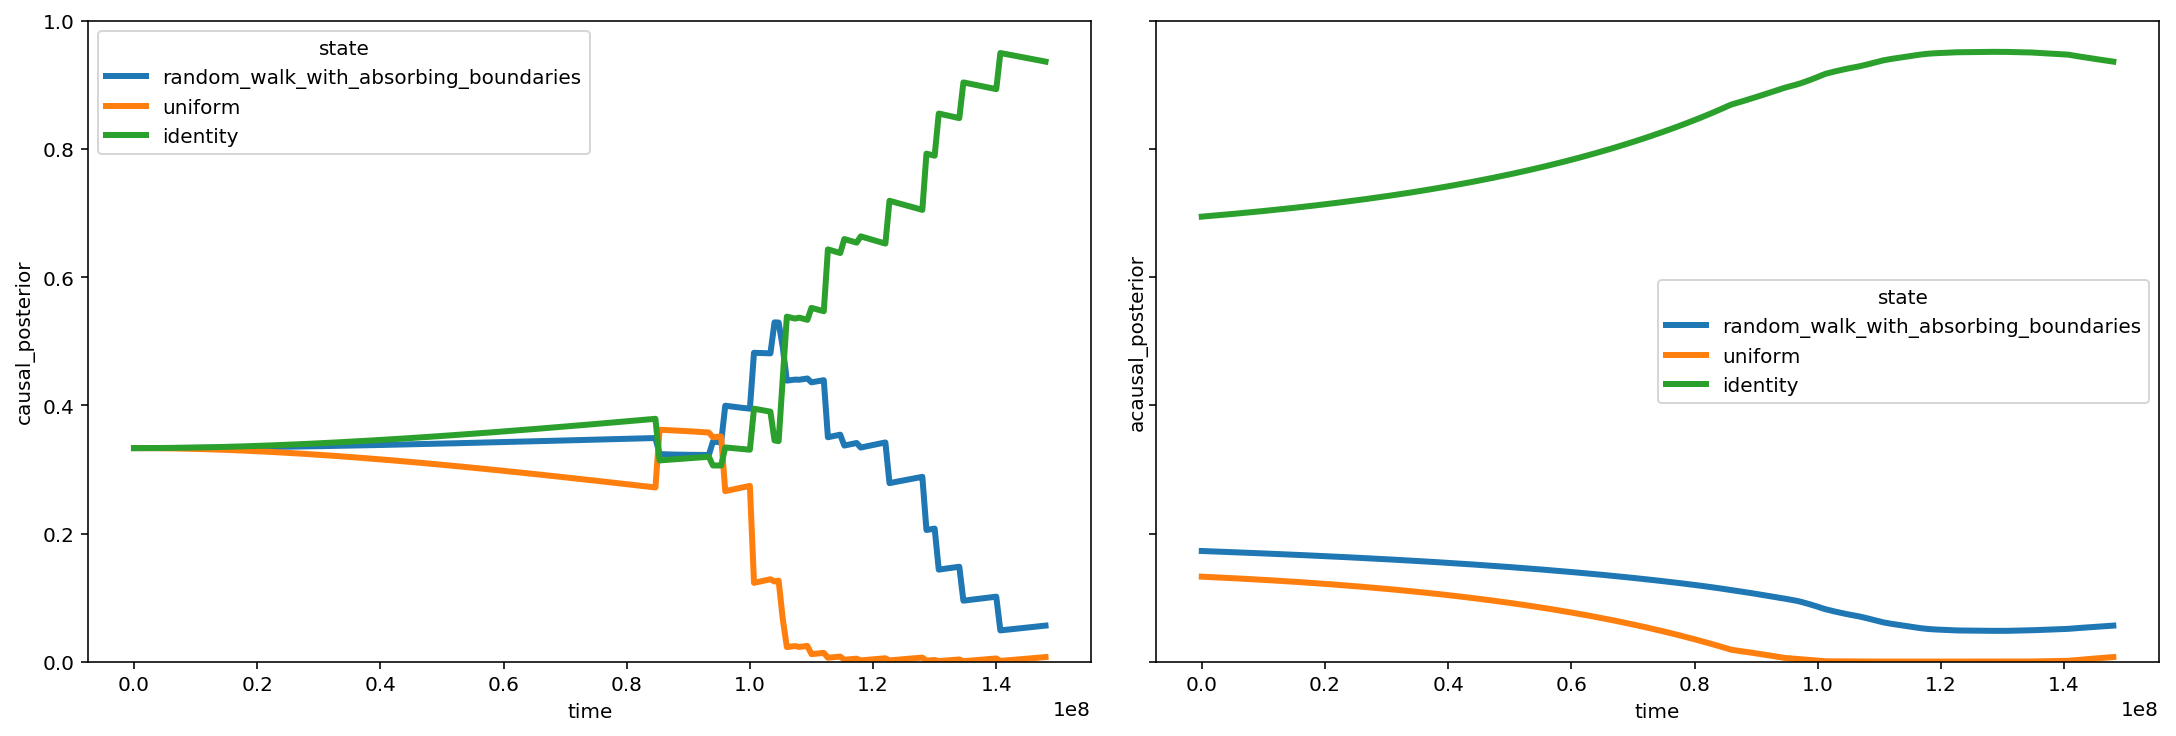

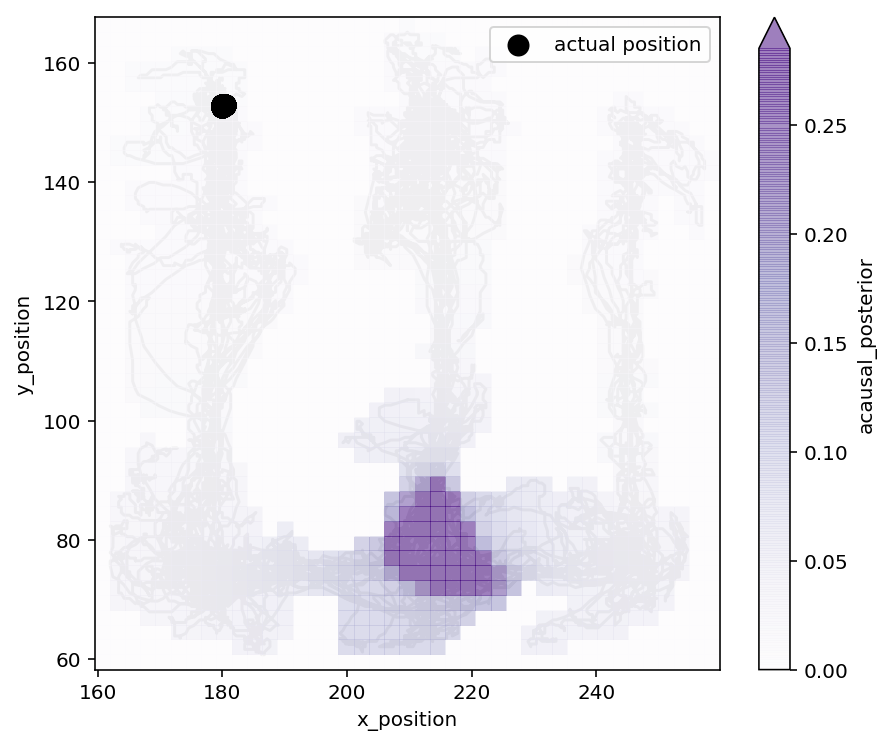

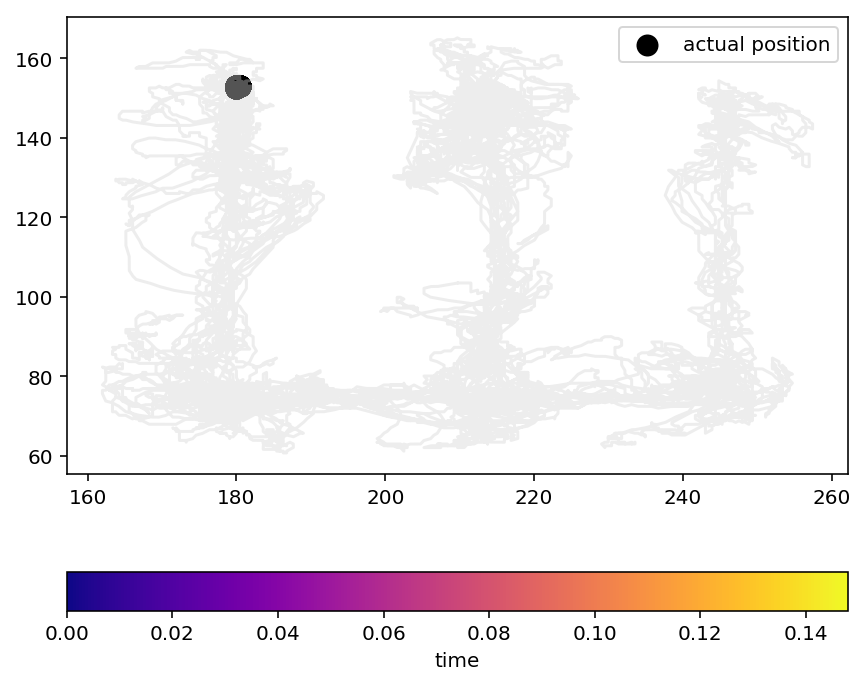

In [179]:
ripple_number = 187
result = results[ripple_number - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.5)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.5, zorder=0)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend()

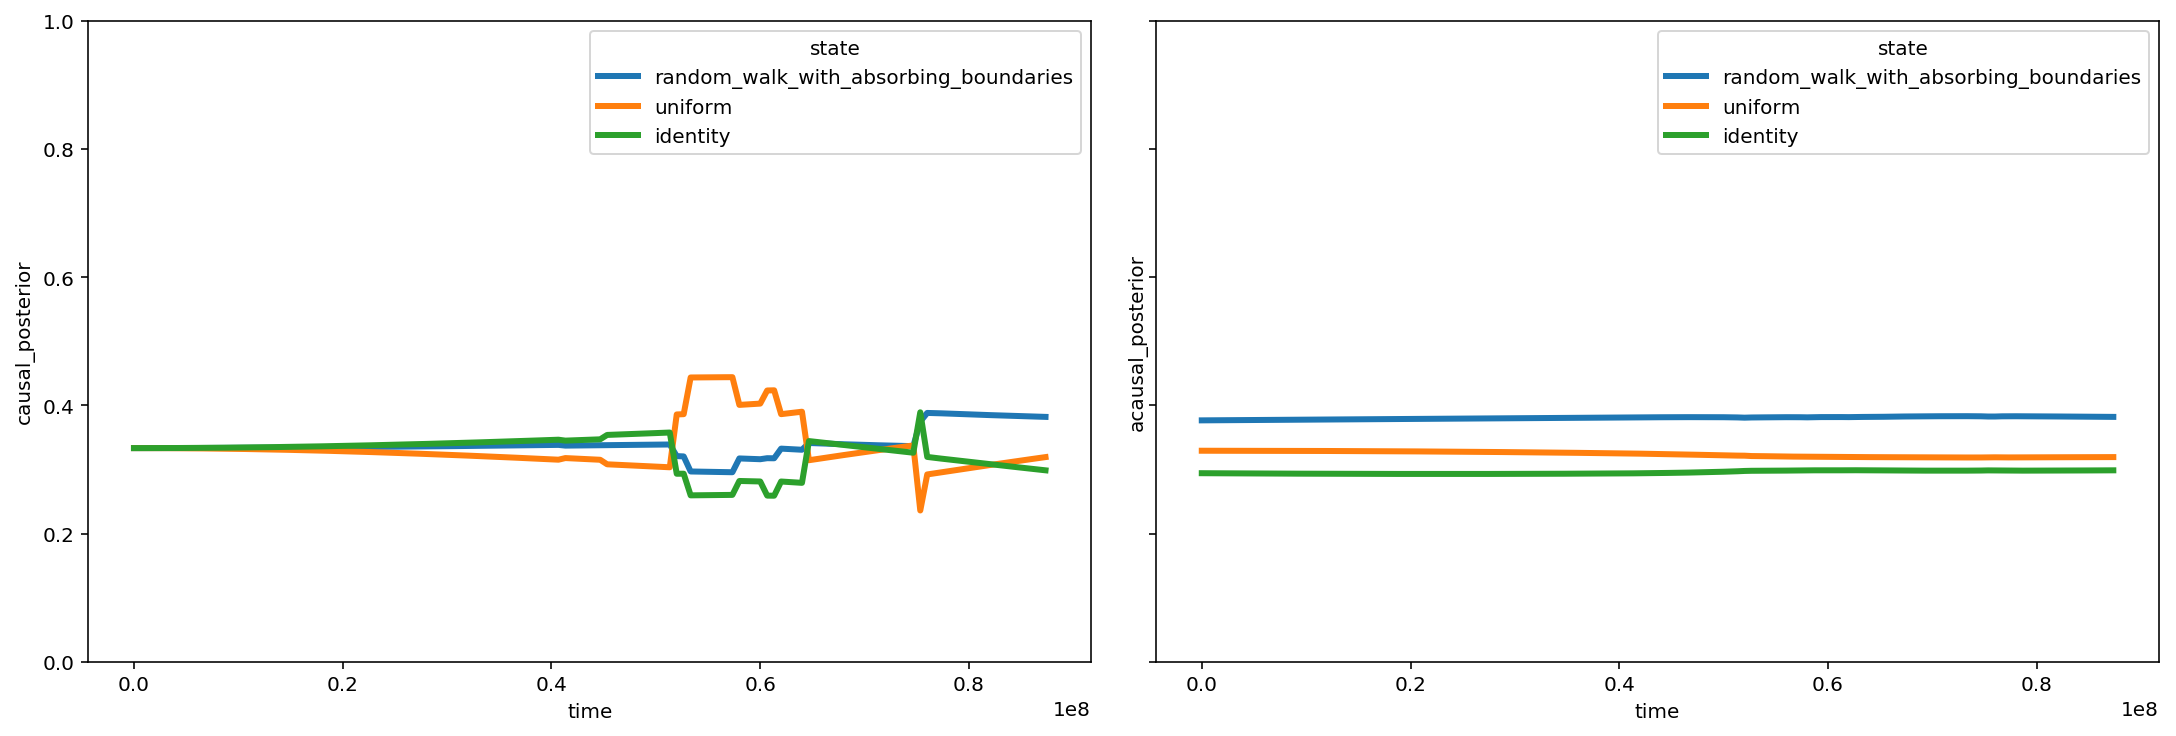

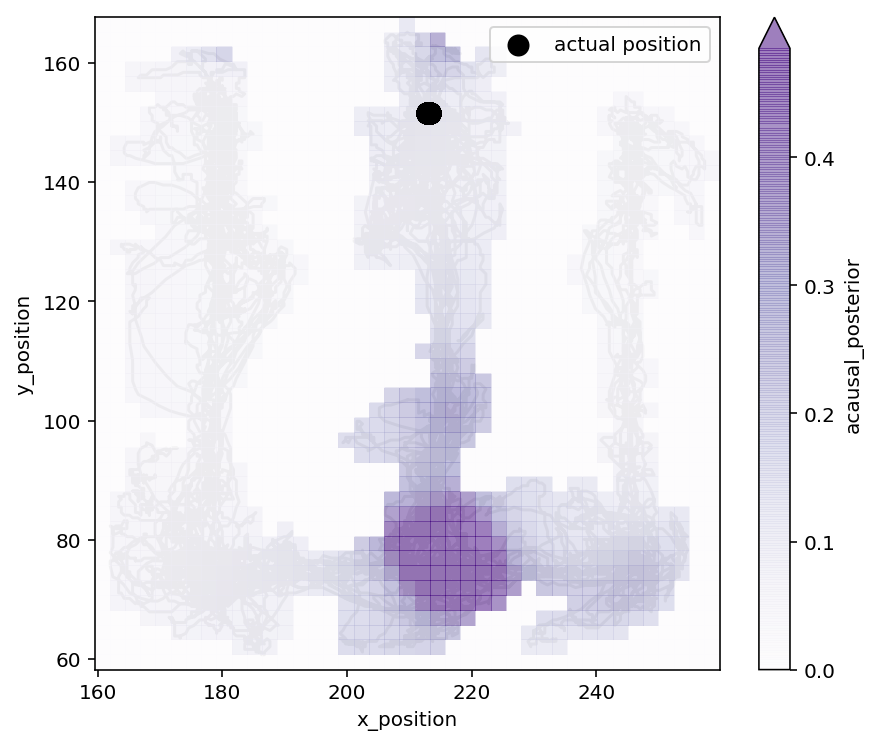

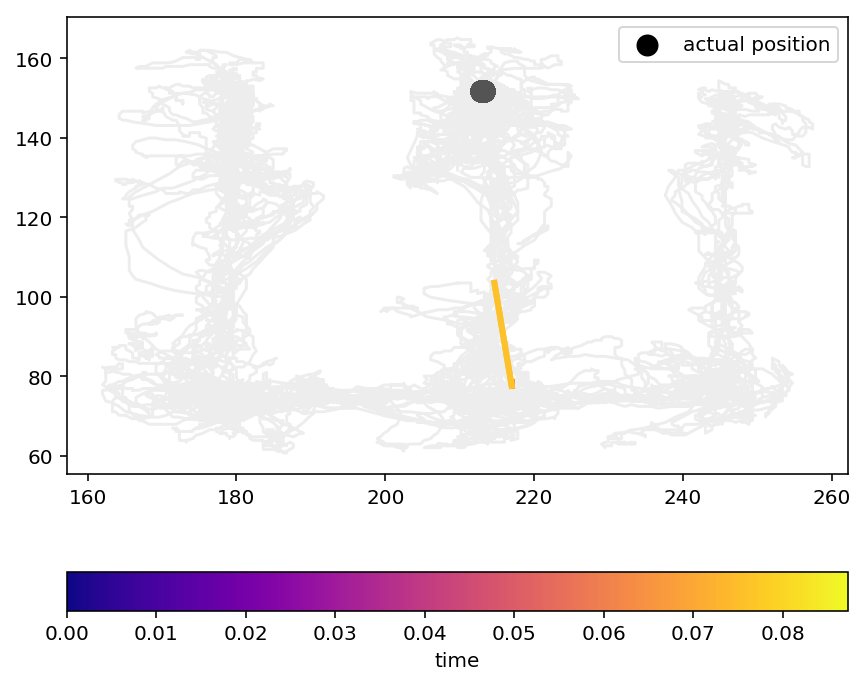

In [226]:
ripple_number = 29
result = results[ripple_number - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.5)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.5, zorder=0)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend()

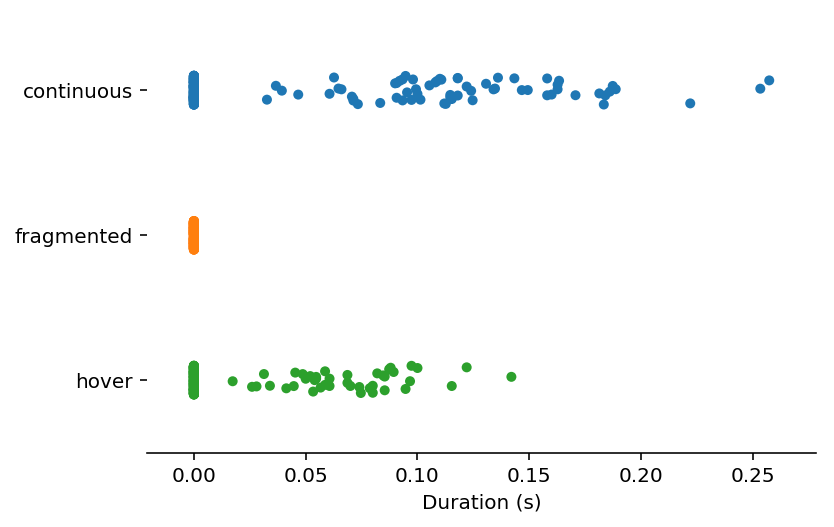

In [195]:
sns.stripplot(data=duration.iloc[:, :3].rename(columns=lambda c: c.split('_')[0]),
              order=['continuous', 'fragmented', 'hover'],
              orient='horizontal')
plt.xlabel('Duration (s)')
sns.despine(left=True)

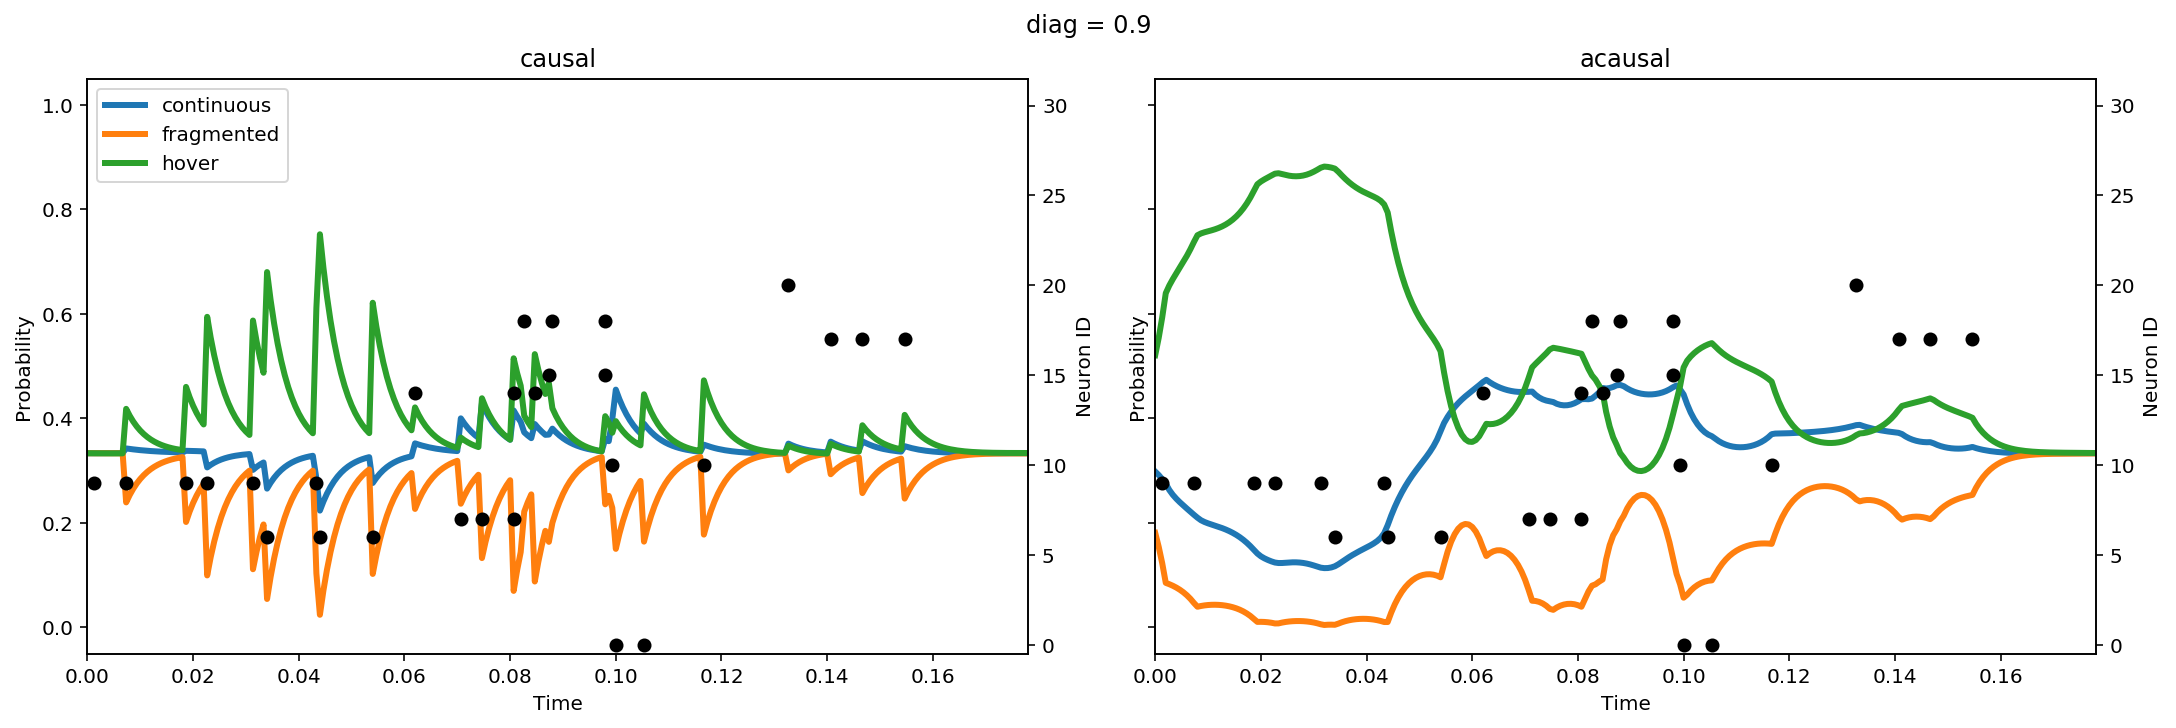

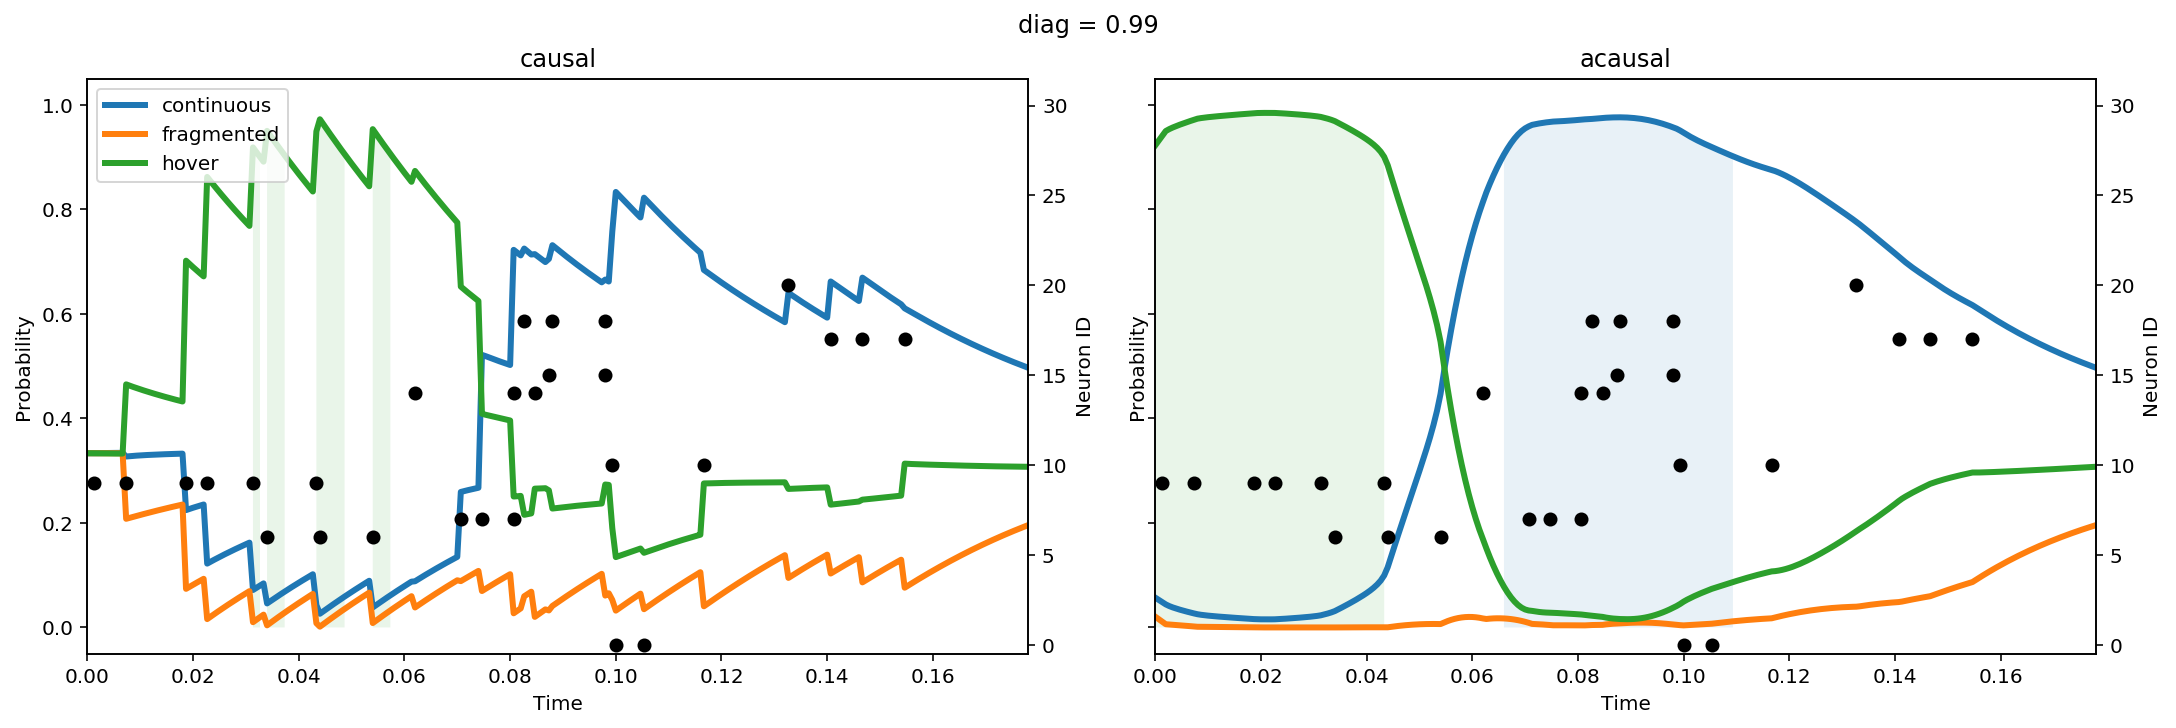

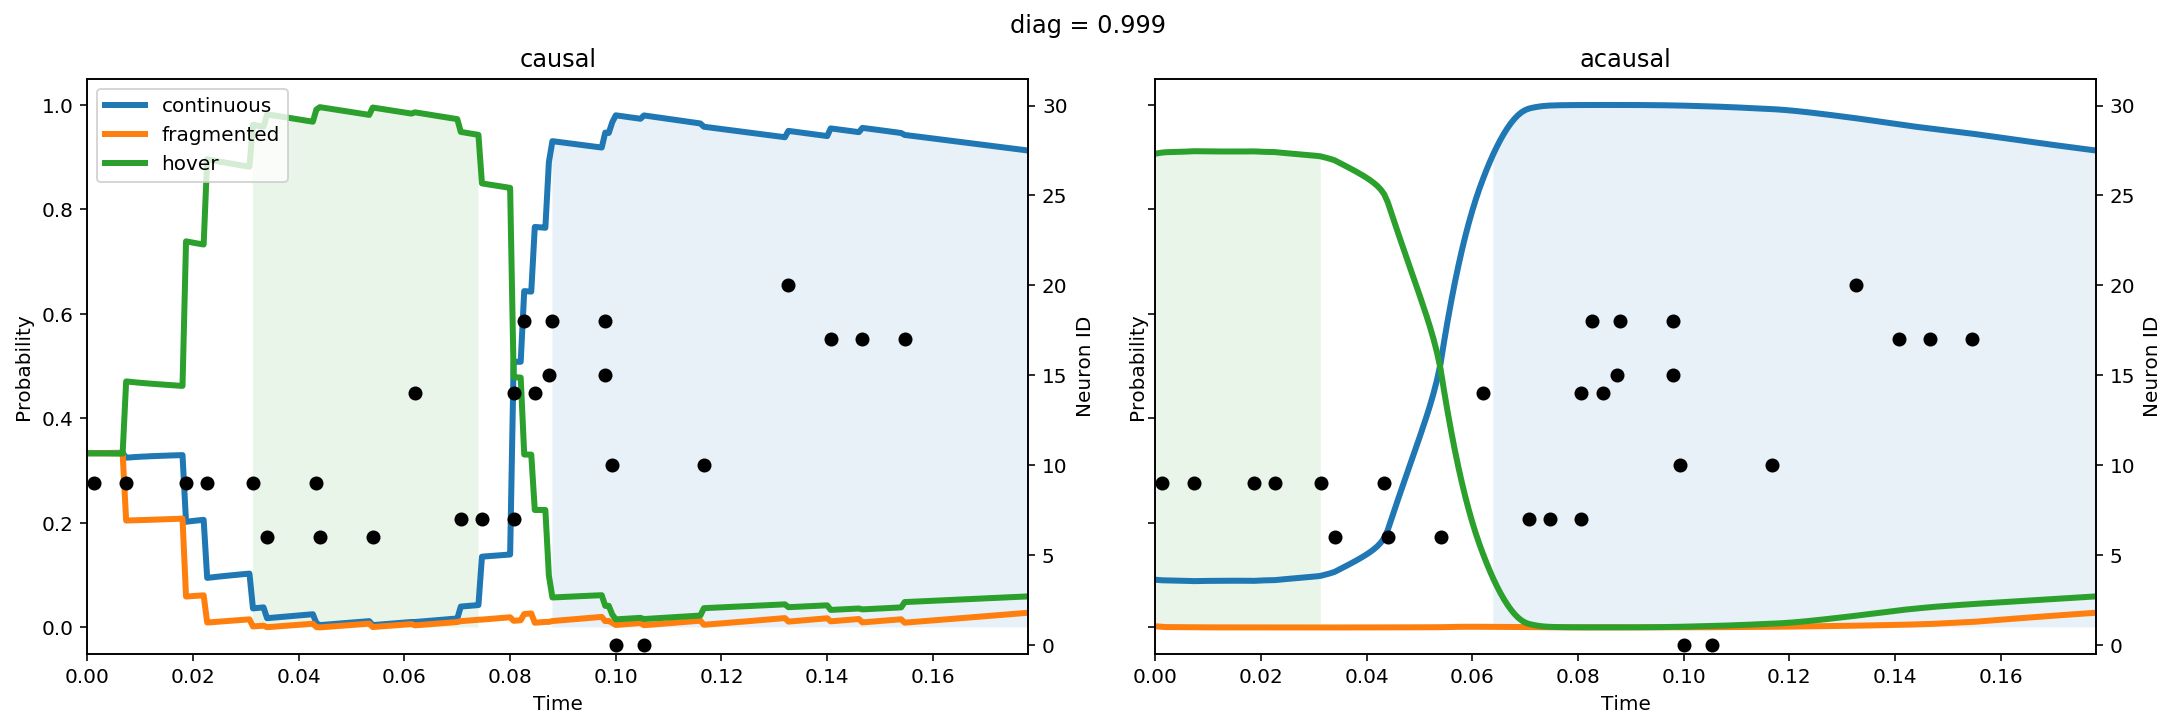

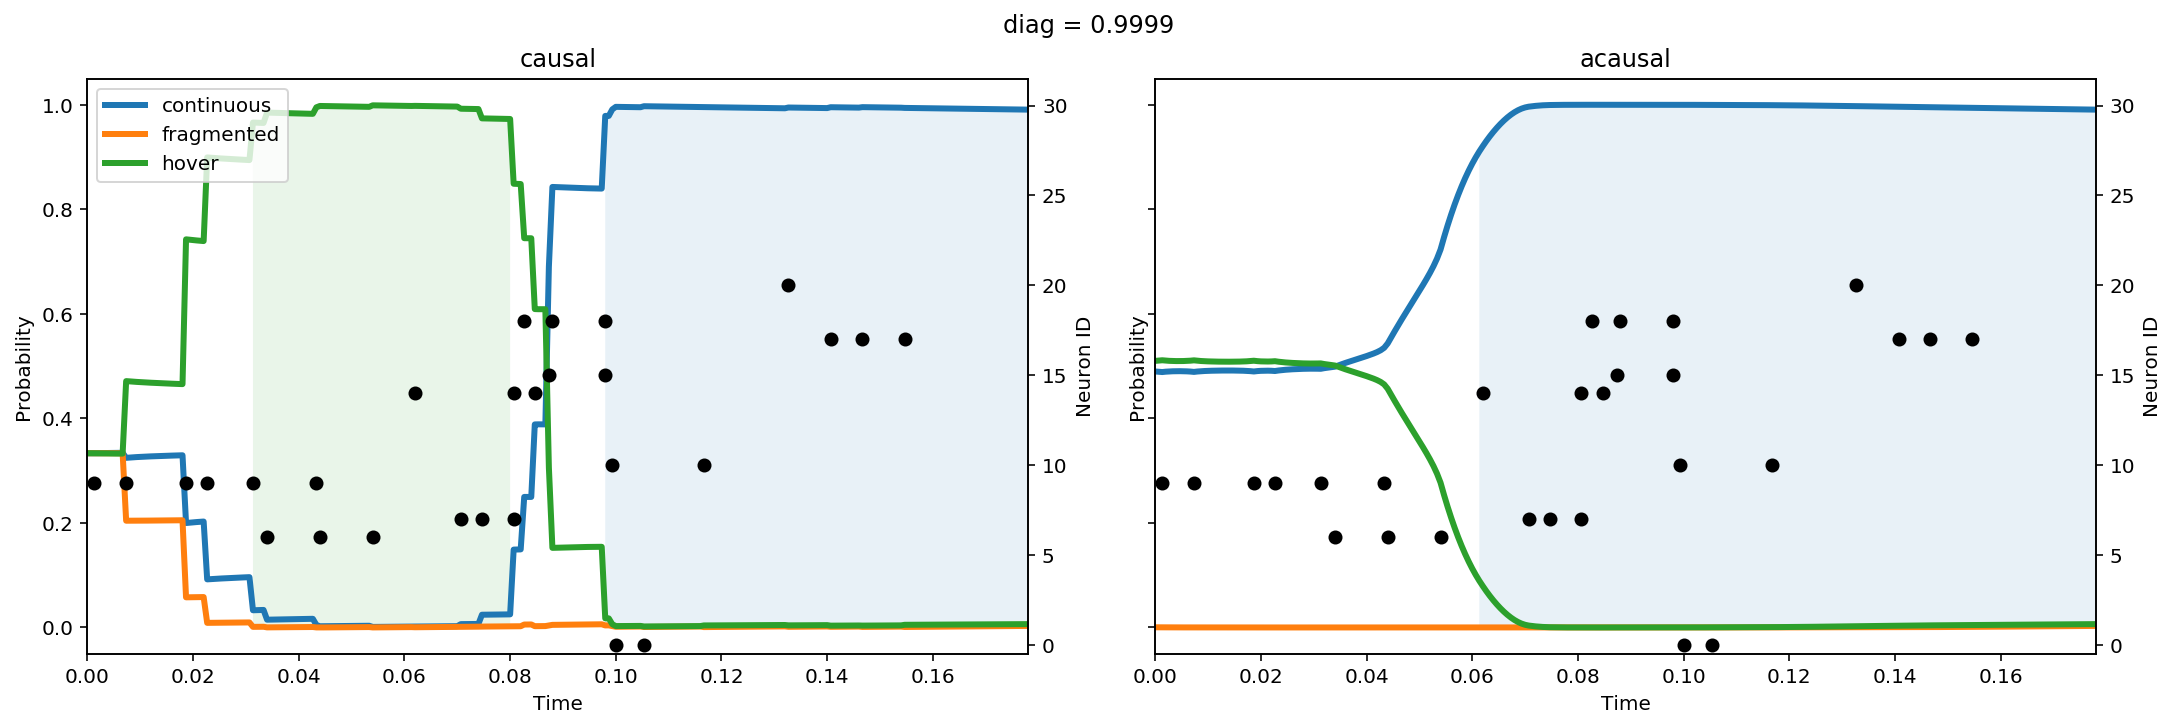

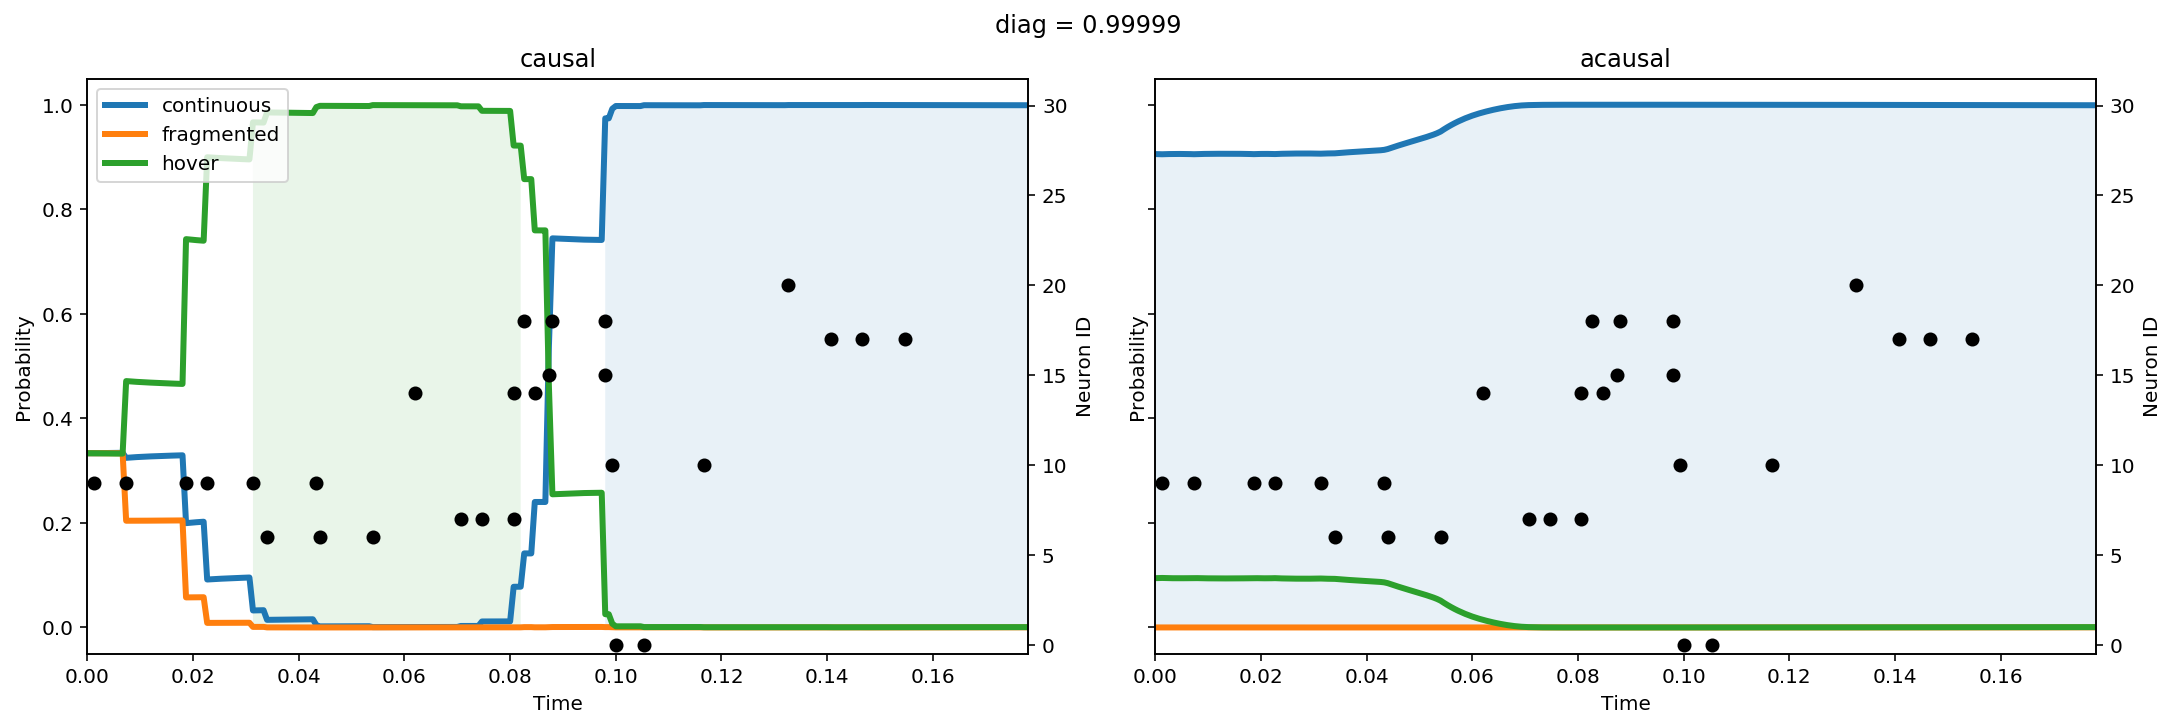

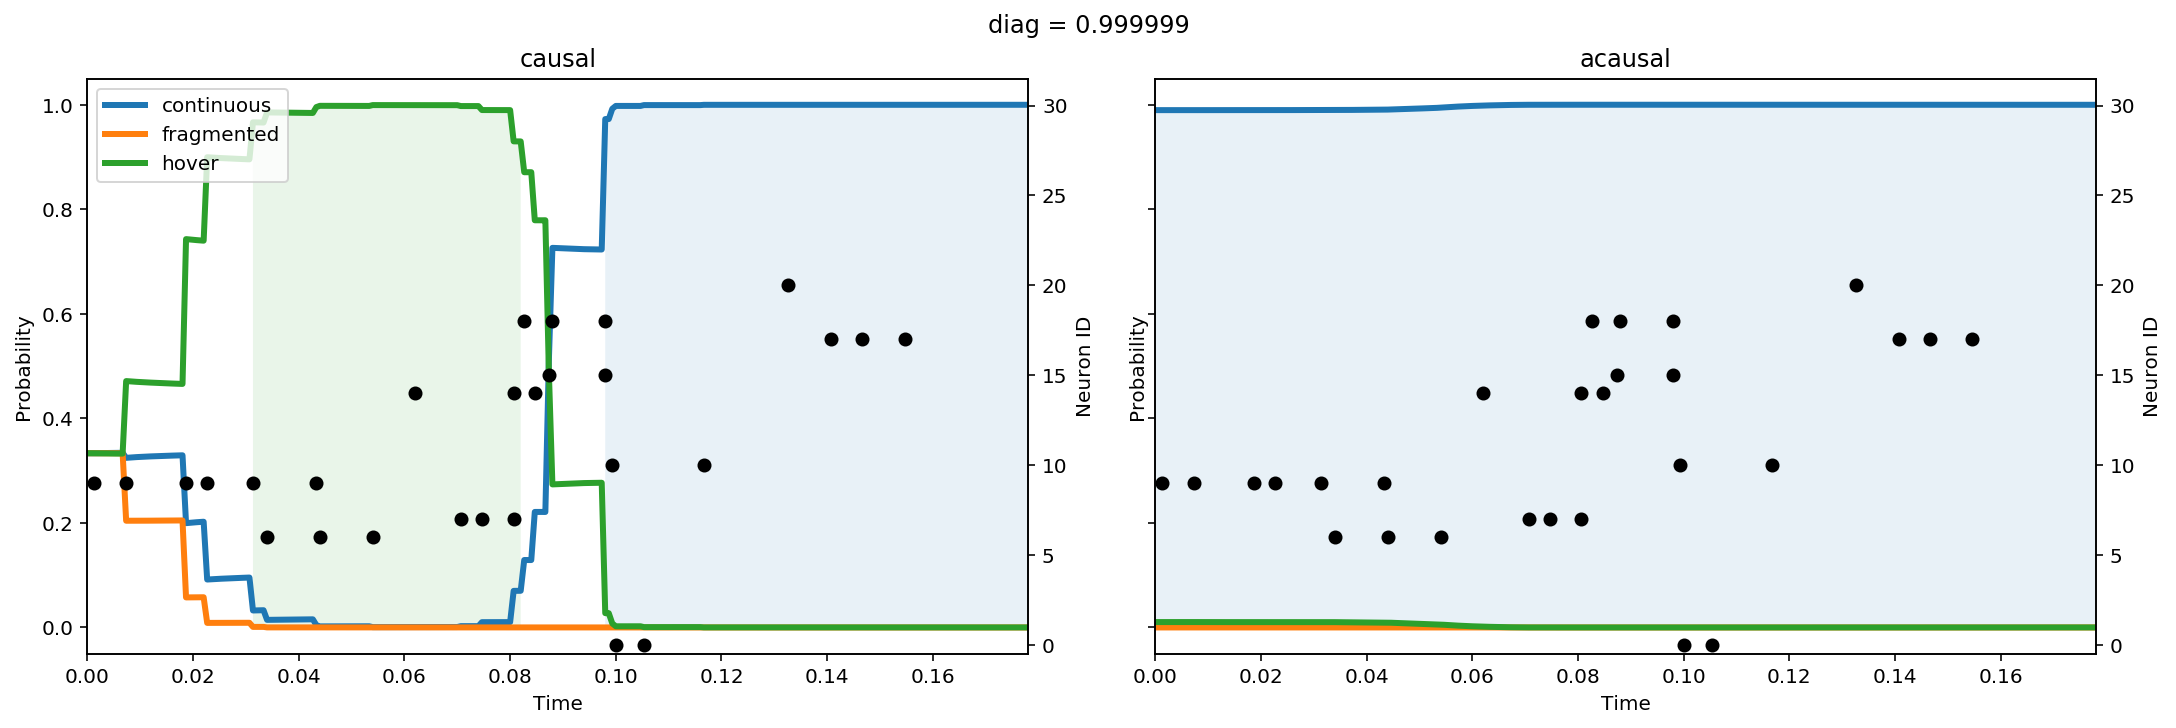

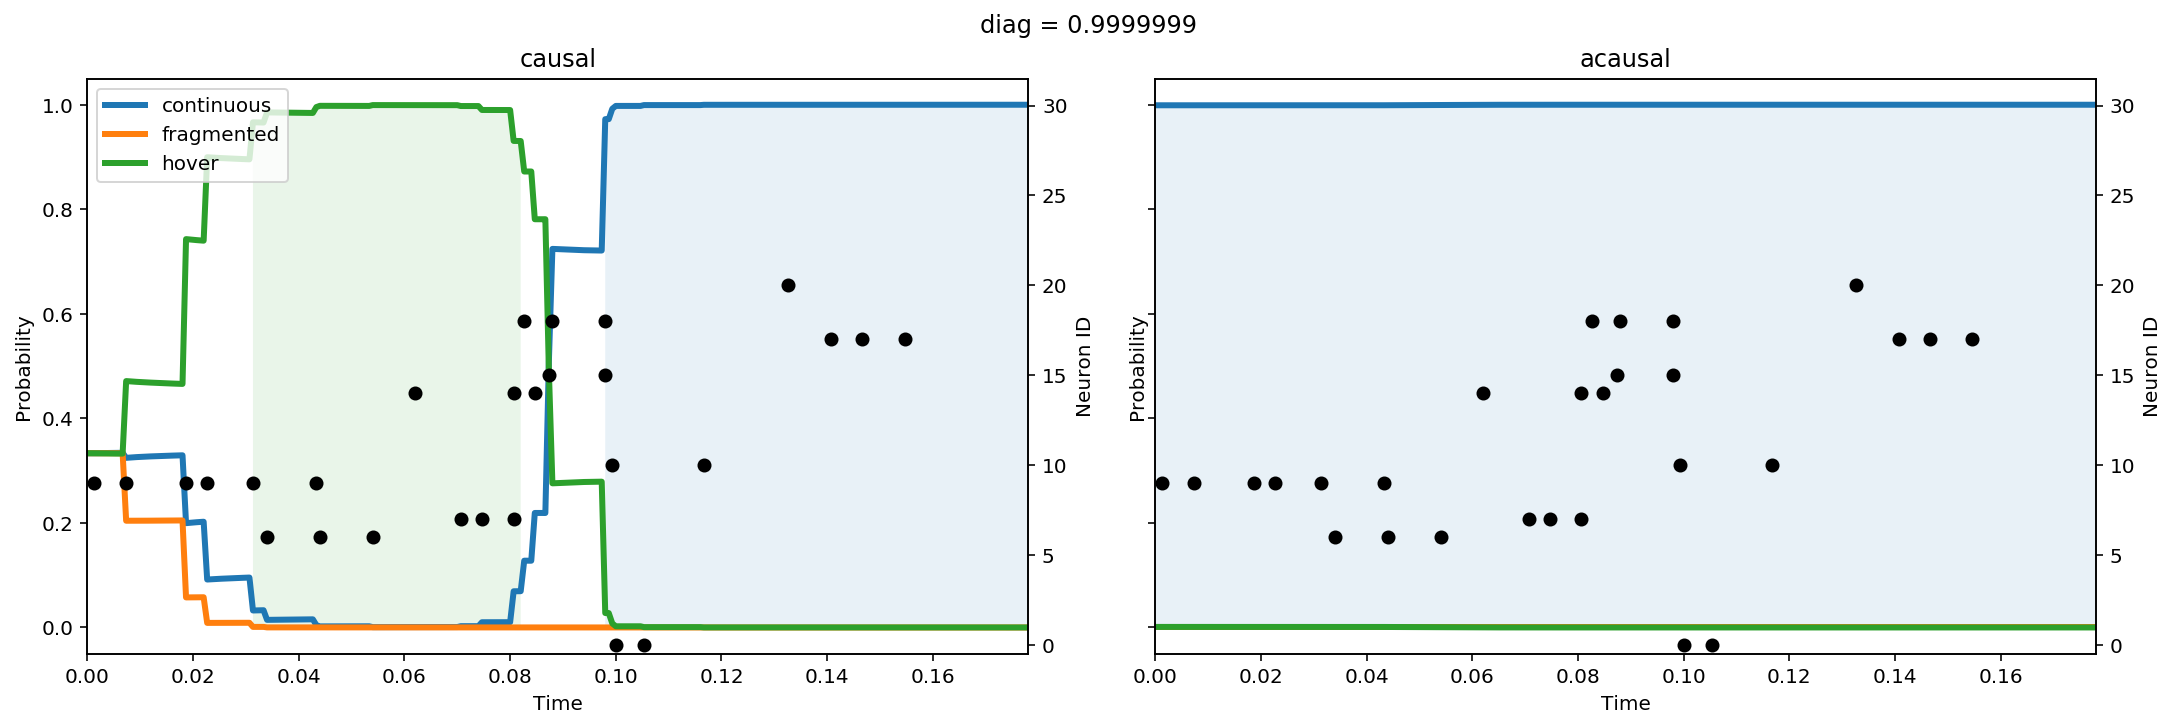

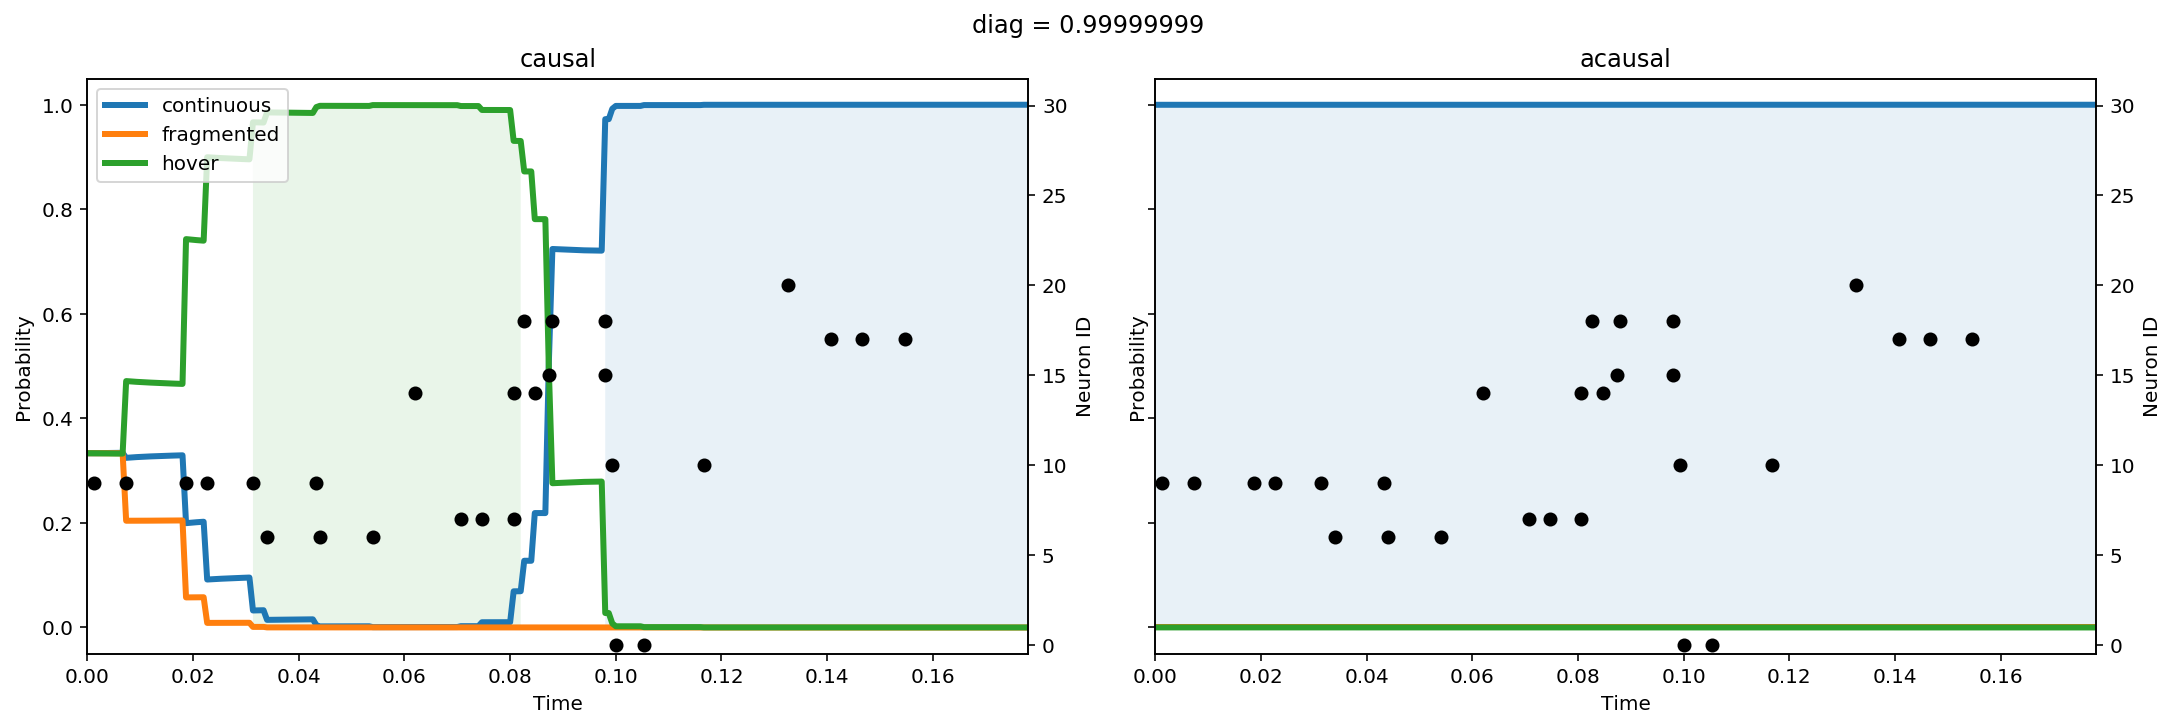

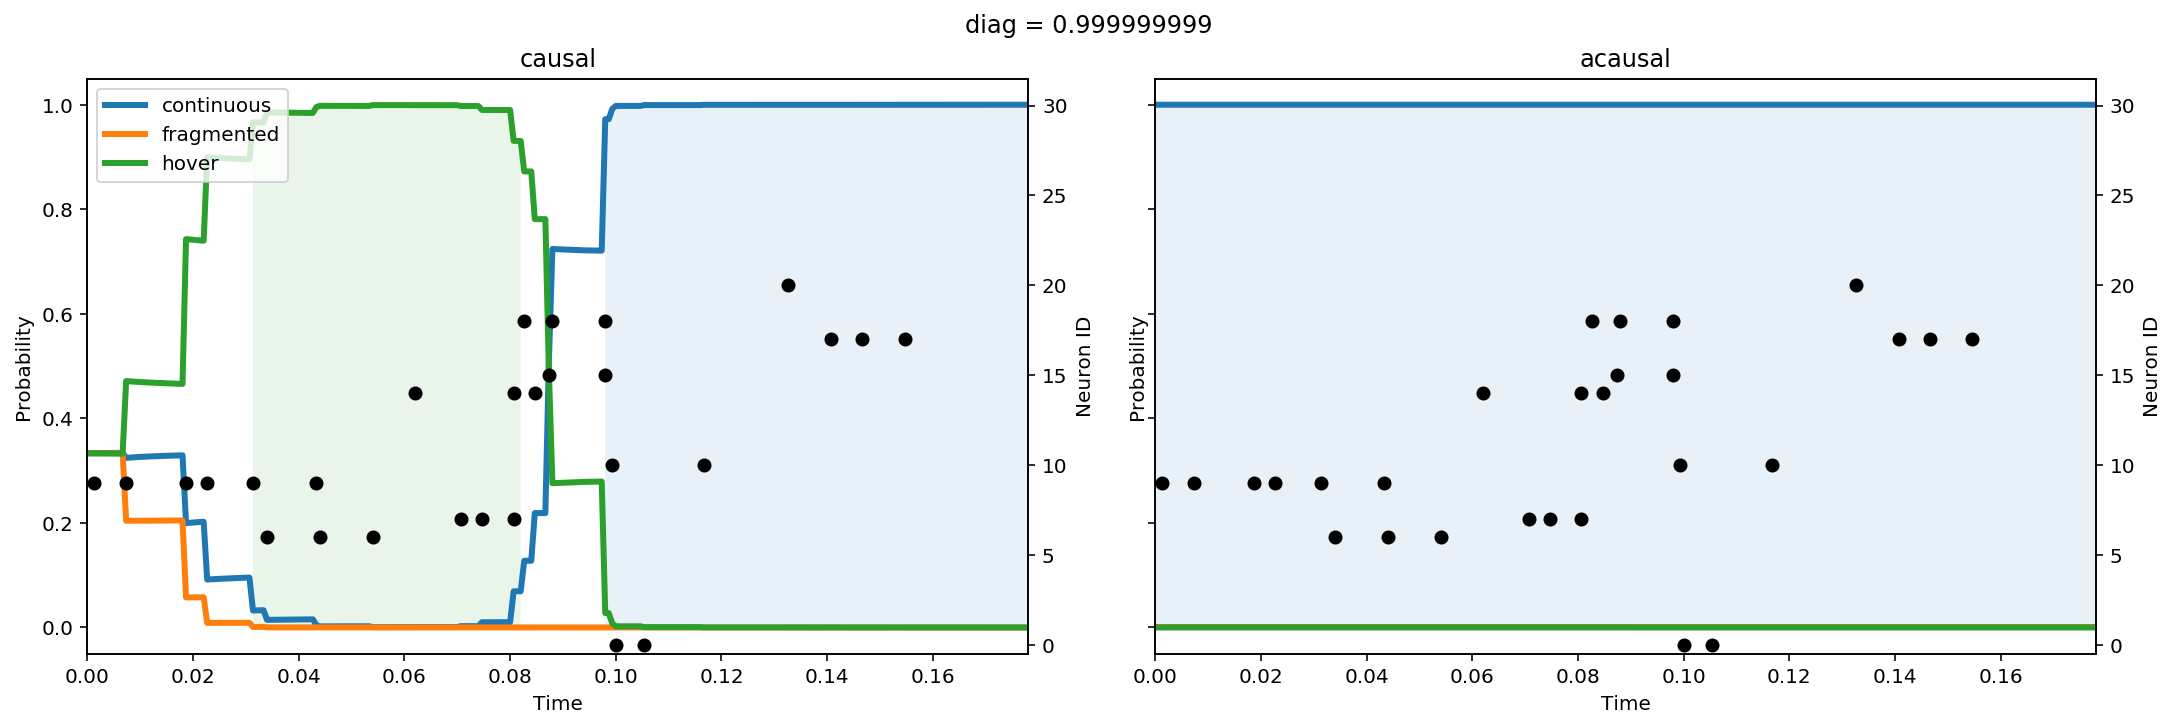

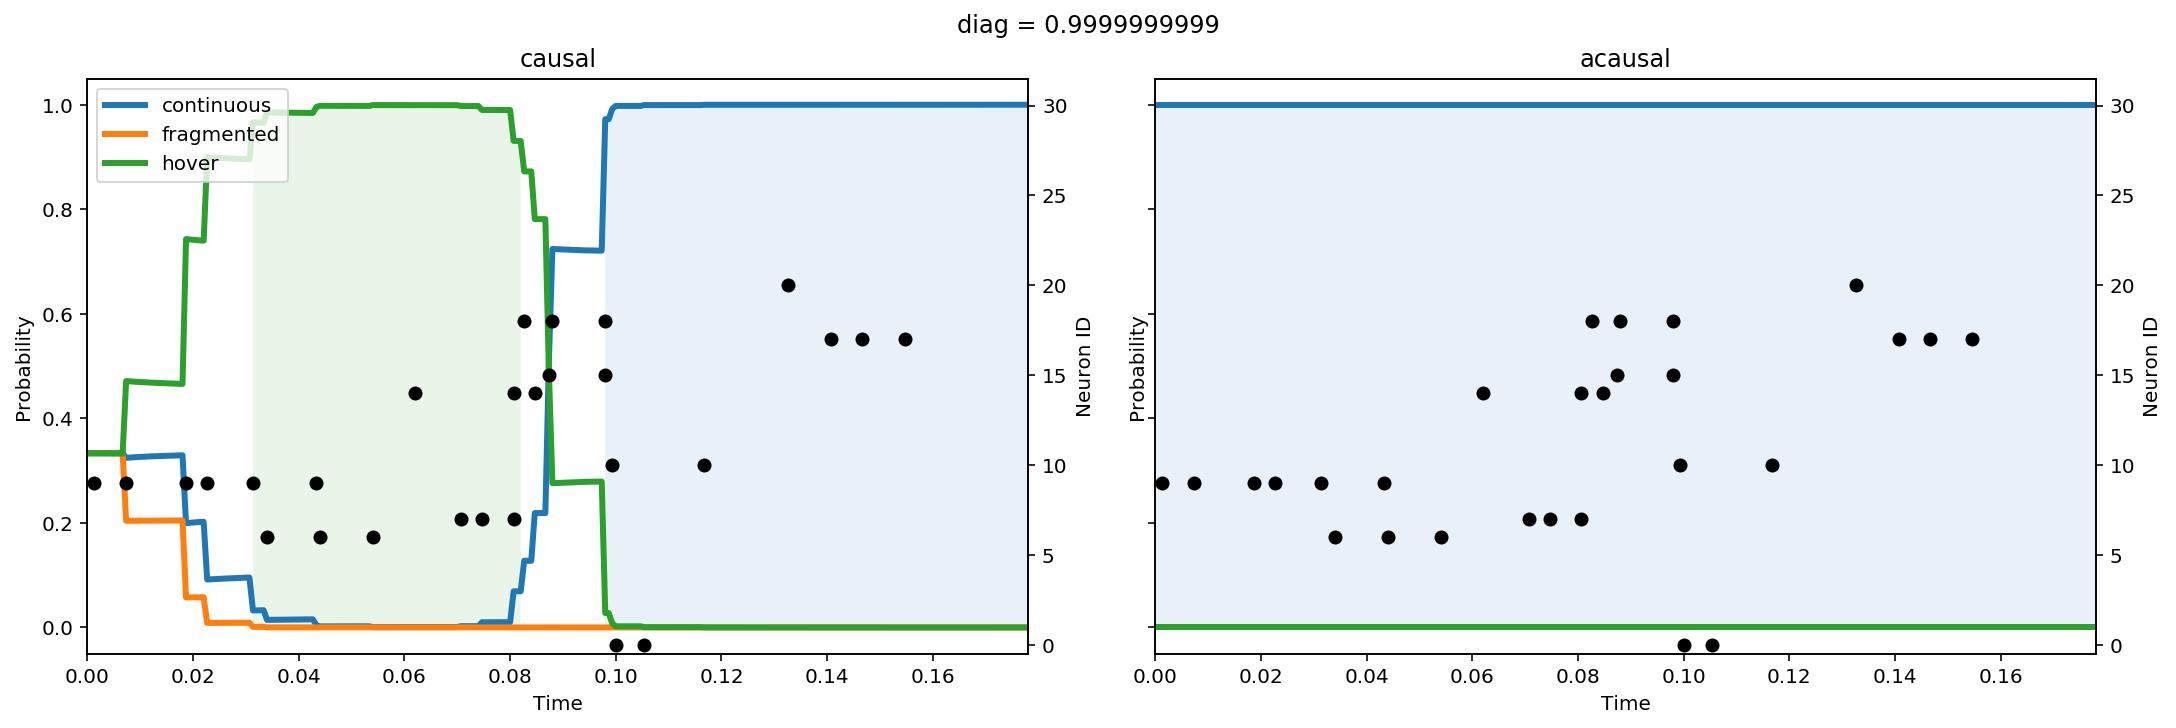

In [211]:
from copy import deepcopy

def plot_classifier_probabilities(results, spikes, time, classifier):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5),
                             sharex=True, sharey=True,
                             constrained_layout=True)
    transition_to_category = [
        ('random_walk_with_absorbing_boundaries', 'continuous'),
        ('uniform', 'fragmented'),
        ('identity', 'hover')]

    probabilities = classifier.predict_proba(results)
    posterior_names = ['causal_posterior', 'acausal_posterior']
    spike_time_ind, neuron_ind = np.nonzero(spikes)
    n_neurons = spikes.shape[1]
    
    for ax, posterior_name in zip(axes.flat, posterior_names):
        for state, category in transition_to_category:
            p = probabilities[posterior_name].sel(state=state).values
            ax.plot(probabilities.time, p, label=category, linewidth=3, zorder=1)
            ax.fill_between(probabilities.time, p, alpha=0.1, where=p>0.9, zorder=-100)
        ax.set_xlim((time.min(), time.max()))
        ax.set_ylim((-0.05, 1.05))
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        ax.set_title(posterior_name.split('_')[0])
        
        twin_ax = ax.twinx()
        twin_ax.scatter(time[spike_time_ind], neuron_ind, color='black', zorder=100)
        twin_ax.set_ylim((-0.5, n_neurons - 0.5))
        twin_ax.set_ylabel('Neuron ID')
    axes[0].legend(loc='upper left')

c = deepcopy(classifier)
ripple_number = 284
diags = 1 - (10.0**(-np.arange(1, 11)))

for ind, diag in enumerate(tqdm(diags)):
    c.fit_discrete_state_transition(diag)
    result = c.predict(ripple_spikes.loc[ripple_number],
                       time=ripple_spikes.loc[ripple_number].index.total_seconds().values)
    plot_classifier_probabilities(result, ripple_spikes.loc[ripple_number].values, result.time, c)
    plt.suptitle(f'diag = {diag}')
    plt.savefig(f'classifier_{ind + 1:02d}.png', bbox_inches='tight')